# 2021 Stack Overflow Survey Results analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## Data Exploration

In [2]:
# read data to dataframe
df_2021 = pd.read_csv('./survey_results_public.csv', encoding = "utf-8")
df_2021_schema = pd.read_csv('./survey_results_schema.csv', encoding = "utf-8")


First, we want to look at our data and understand the shape of it, the list of columns,
and look at some values.

In [3]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83439 entries, 0 to 83438
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ResponseId                    83439 non-null  int64  
 1   MainBranch                    83439 non-null  object 
 2   Employment                    83323 non-null  object 
 3   Country                       83439 non-null  object 
 4   US_State                      14920 non-null  object 
 5   UK_Country                    4418 non-null   object 
 6   EdLevel                       83126 non-null  object 
 7   Age1stCode                    83243 non-null  object 
 8   LearnCode                     82963 non-null  object 
 9   YearsCode                     81641 non-null  object 
 10  YearsCodePro                  61216 non-null  object 
 11  DevType                       66484 non-null  object 
 12  OrgSize                       60726 non-null  object 
 13  C

This dataset has 83439 entries and 48 columns. Only 3 columns are numerical.

In [4]:
df_2021.describe()

,ResponseId,CompTotal,ConvertedCompYearly
count,83439.000000,4.718300e+04,4.684400e+04
mean,41720.000000,2.119407e+69,1.184262e+05
std,24086.908893,4.603702e+71,5.272944e+05
min,1.000000,0.000000e+00,1.000000e+00
25%,20860.500000,1.600000e+04,2.702500e+04
50%,41720.000000,6.700000e+04,5.621100e+04
75%,62579.500000,1.400000e+05,1.000000e+05
max,83439.000000,1.000000e+74,4.524131e+07


Some values in CompTotal column are extremely large. We may have to deal with them later.

## Question 1: What programming languages were used the most among all respondents and in different countries?

Let's look at the values in the column **LanguageHaveWorkedWith**, containing used languages.

In [5]:
data_col = 'LanguageHaveWorkedWith'
df_2021[data_col].value_counts()

Python                                                                                         1337
HTML/CSS;JavaScript;Node.js;TypeScript                                                          811
Java                                                                                            715
HTML/CSS;JavaScript;PHP;SQL                                                                     674
C#                                                                                              597
                                                                                               ... 
Assembly;Bash/Shell;C;C++;HTML/CSS;Java;JavaScript;Matlab;Python;R;SQL;TypeScript                 1
Assembly;C;C#;Delphi;Java;JavaScript;SQL                                                          1
Bash/Shell;Dart;Go;Groovy;Java;JavaScript;Kotlin;Node.js;TypeScript                               1
C++;Groovy;HTML/CSS;Java;JavaScript;Kotlin;Node.js;Objective-C;Python;Ruby;Swift;TypeScript       1


We can see, that it was a multiple choice question, and all the values are stored together, separated by semicolon.  
In order to analyze this data, we will need to count single languages.  

The following functions will help to split the values in the column, calculate proportions, and plot the results.

In [6]:
from collections import defaultdict


def get_possible_vals(col):
    '''
    INPUT 
        col - pandas Series, the column with semicolon separated values
    OUTPUT
        Set of single values in the column
    '''

    return(set([val.strip() for sublist in col.dropna().str.split(";").tolist() for val in sublist]))


def get_total_counts(df, col, col_suffix=''):
    '''
    INPUT 
        df - DataFrame, data
        col - string, holding the column name
        col_suffix - string, suffix for the 'count' column in the resulting dataframe
    OUTPUT
        new_df - DataFrame, value counts
    '''

    df_val_counts = df[col].value_counts().reset_index()
    df_val_counts = df_val_counts.rename(columns={'index': 'value', col: 'count'})
    possible_vals = get_possible_vals(df[col])

    new_df = defaultdict(int)
    #loop through the list of possible values
    for val in possible_vals:
        #loop through rows
        for idx in range(df_val_counts.shape[0]):
            row_vals = df_val_counts['value'][idx].split(";")
            if val in row_vals:
                new_df[val] += int(df_val_counts['count'][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = ['value', 'count'+col_suffix]
    return new_df


def clean_and_plot(df, col, col_suffix='', title='', plot=True):
    '''
    INPUT 
        df - DataFrame, data
        col - string, holding the column name
        col_suffix - string, suffix for the 'count' column in the resulting dataframe
        title - string, the title of plot
        plot - bool, whether or not a plot needed
    OUTPUT
        df_prop - DataFrame, proportions of the column values
        Displays a plot for proportions of the column values.
    '''

    df_counts = get_total_counts(df, col, col_suffix)

    df_prop = df_counts.sort_values('count'+col_suffix, ascending=True).set_index('value')
    df_prop = df_prop/df[col].shape[0]
    if plot:
        df_prop.plot(kind='barh',figsize=(10,0.25*len(df_prop)), legend=None, ylabel='Y').grid(axis='x');
        plt.ylabel('')
        plt.title(title+', proportion')
        plt.show()
    return df_prop


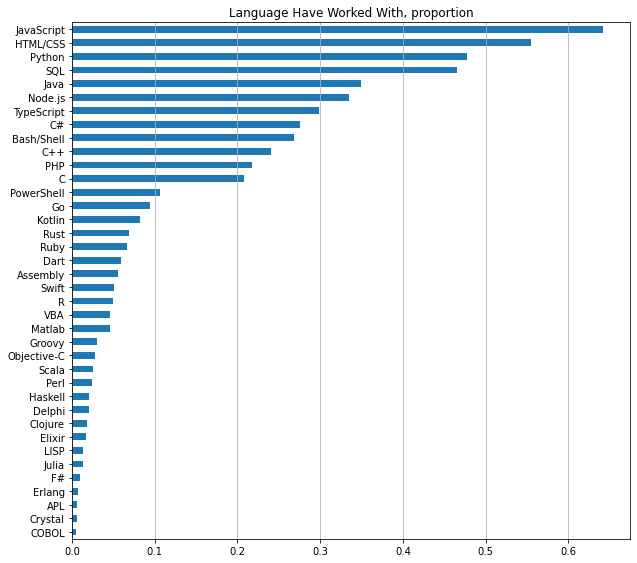

In [7]:
title0 = 'Language Have Worked With'
df_lang_worked = clean_and_plot(df_2021, col=data_col, title=title0)


We can see,that JavaScript, HTML/CSS, Python and SQL were used the most. JavaScript is the clear leader.
On the other hand COBOL, Crystal, APL, Erlang are rarely used.

I want to create a wordcloud with this data and use it in my blog.

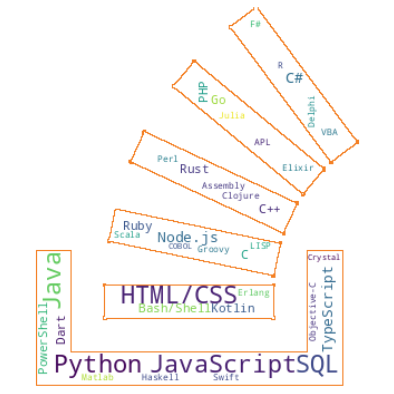

In [8]:
# Some of the code used from https://amueller.github.io/word_cloud/auto_examples/parrot.html

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude

df_lang = df_lang_worked.copy().reset_index()
df_lang['count'] = (df_lang['count'] * 10000).astype(int)

tuples = [tuple(x) for x in df_lang.values]
so_color = np.array(Image.open('so_logo2.png'))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
so_color = so_color[::3, ::3]

# create mask  white is "masked out"
so_mask = so_color.copy()
so_mask[so_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(so_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
so_mask[edges > .08] = 255

image_colors = ImageColorGenerator(so_color)
#wordcloud = WordCloud(background_color="#302d2b", mask=so_mask, contour_width=3, contour_color='firebrick').generate_from_frequencies(dict(tuples))
wordcloud = WordCloud(background_color="white", mask=so_mask, contour_width=1, contour_color='#f48024',
                    random_state=42, relative_scaling=0).generate_from_frequencies(dict(tuples))
plt.figure(figsize=[10,7])
#plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("wordcloud.png");

I am curious if distribution of languages is different by countries.  

First, let's see what countries do respondents represent.

In [9]:
df_2021['Country'].value_counts()

United States of America                                15288
India                                                   10511
Germany                                                  5625
United Kingdom of Great Britain and Northern Ireland     4475
Canada                                                   3012
                                                        ...  
Papua New Guinea                                            1
Saint Kitts and Nevis                                       1
Saint Vincent and the Grenadines                            1
Brunei Darussalam                                           1
Tuvalu                                                      1
Name: Country, Length: 181, dtype: int64

I want to compare top 5 countries from that list plus 2 other big countries: Russia and China.

In [10]:
df_us = df_2021[df_2021['Country']=='United States of America']
df_in = df_2021[df_2021['Country']=='India']
df_ge = df_2021[df_2021['Country']=='Germany']
df_uk = df_2021[df_2021['Country']=='United Kingdom of Great Britain and Northern Ireland']
df_ca = df_2021[df_2021['Country']=='Canada']
df_ru = df_2021[df_2021['Country']=='Russian Federation']
df_ch = df_2021[df_2021['Country']=='China']


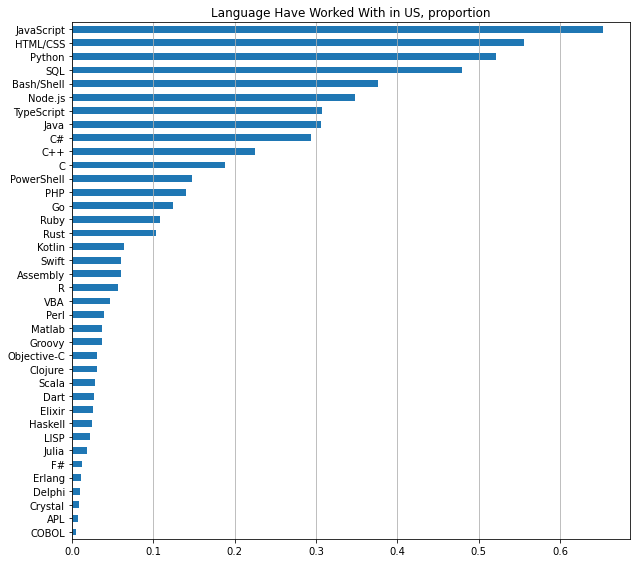

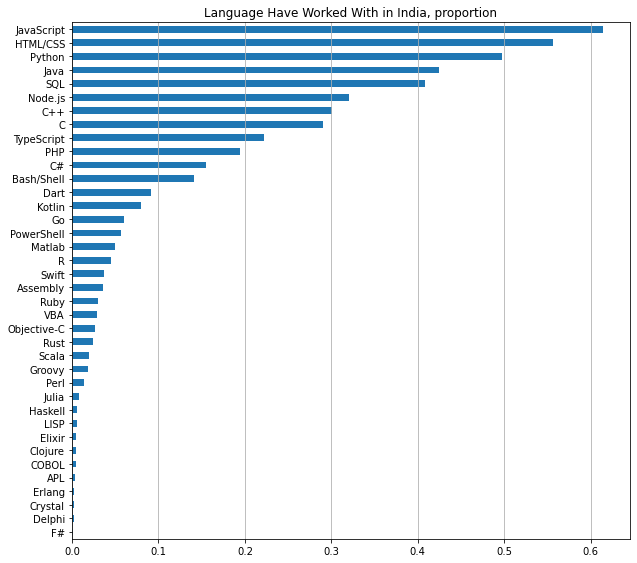

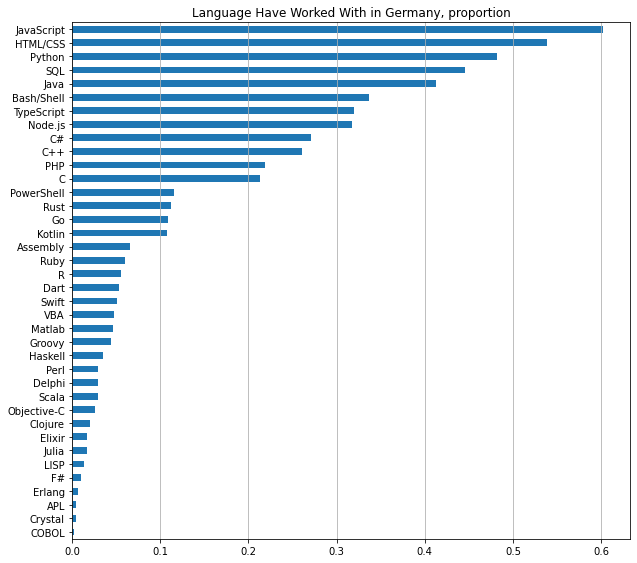

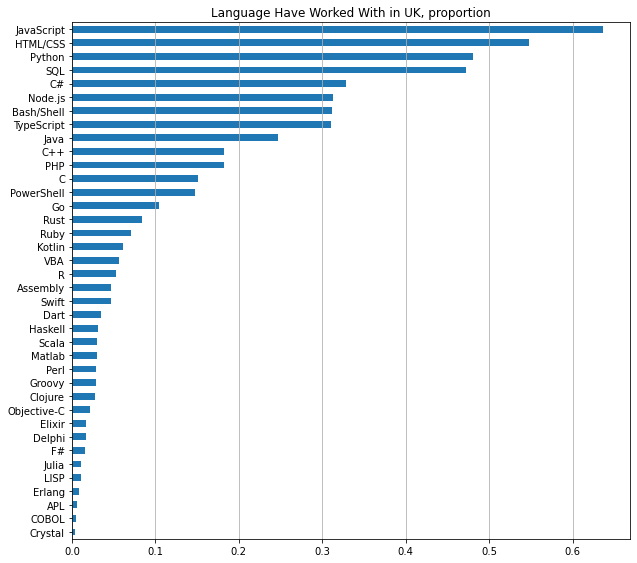

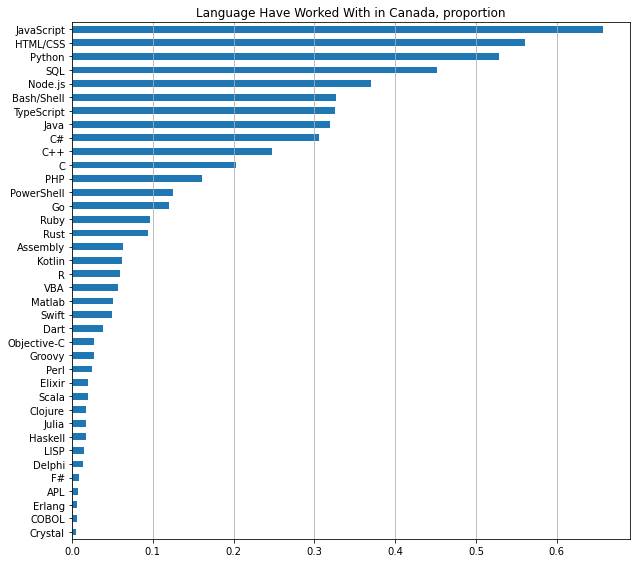

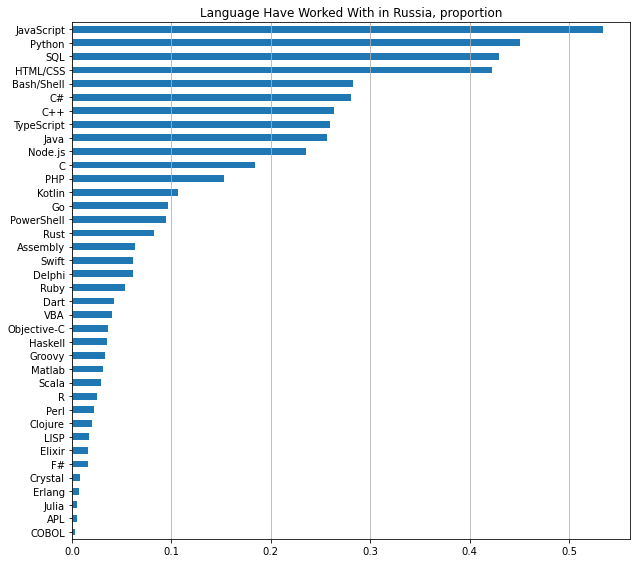

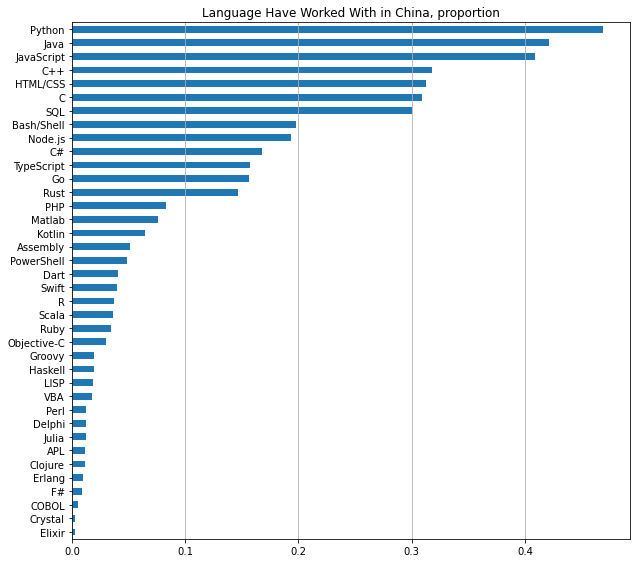

In [11]:
df_lang_worked_us = clean_and_plot(df_us, col=data_col, col_suffix='_us', title=title0+' in US')
df_lang_worked_in = clean_and_plot(df_in, col=data_col, col_suffix='_in', title=title0+' in India')
df_lang_worked_ge = clean_and_plot(df_ge, col=data_col, col_suffix='_ge', title=title0+' in Germany')
df_lang_worked_uk = clean_and_plot(df_uk, col=data_col, col_suffix='_uk', title=title0+' in UK')
df_lang_worked_ca = clean_and_plot(df_ca, col=data_col, col_suffix='_ca', title=title0+' in Canada')
df_lang_worked_ru = clean_and_plot(df_ru, col=data_col, col_suffix='_ru', title=title0+' in Russia')
df_lang_worked_ch = clean_and_plot(df_ch, col=data_col, col_suffix='_ch', title=title0+' in China')


Looking at these plots we can see that China has different distribution. JavaScript there is only 3rd. Python and Java are at the top. Also, C++ is getting ahead of HTML/CSS, and SQL is only 7th.  

I would like to see the distribution of languages by country on one plot, to be able to better compare proportions.  

First, let's combine data in one DataFrame.

In [12]:
df_lang_worked_joined = df_lang_worked_us.join(
    df_lang_worked_in).join(
    df_lang_worked_ge).join(
    df_lang_worked_uk).join(
    df_lang_worked_ca).join(
    df_lang_worked_ru).join(
    df_lang_worked_ch)
df_lang_worked_joined = df_lang_worked_joined.rename(columns={
        'count_us':'US',
        'count_in':'India',
        'count_ge':'Germany',
        'count_uk':'UK',
        'count_ca':'Canada',
        'count_ru':'Russia',
        'count_ch':'China'
})
df_lang_worked_joined = df_lang_worked_joined.sort_values(by=['US'], ascending=False)
df_lang_worked_joined

,US,India,Germany,UK,Canada,Russia,China
value,,,,,,,
JavaScript,0.653257,0.614594,0.602489,0.636872,0.657703,0.534600,0.408531
HTML/CSS,0.555468,0.555989,0.538667,0.547486,0.561089,0.422659,0.312796
Python,0.521651,0.497859,0.482311,0.480223,0.528884,0.451153,0.469194
SQL,0.479592,0.408049,0.445333,0.471732,0.451527,0.429444,0.300474
Bash/Shell,0.376570,0.141090,0.336889,0.311955,0.327357,0.282904,0.198104
Node.js,0.348051,0.320902,0.317689,0.312626,0.370186,0.235414,0.193365
TypeScript,0.307496,0.222529,0.319644,0.309944,0.325697,0.259159,0.157346
Java,0.306646,0.424222,0.412267,0.247374,0.319721,0.256445,0.420853
C#,0.294152,0.155266,0.271467,0.328939,0.305445,0.280868,0.167773


In [13]:
def line_plot(df,title=''):
    '''
    INPUT 
        df - DataFrame, data
        title - string, the title of plot
    OUTPUT
        Displays a line plot for proportions of the column values.
    '''
    df.plot(kind='line',figsize=(15,8),rot=75,colormap='tab10').grid(axis='x');
    plt.xticks(np.arange(len(df.index)), df.index);
    plt.xlabel('')
    plt.title(title+', proportion')
    plt.show()


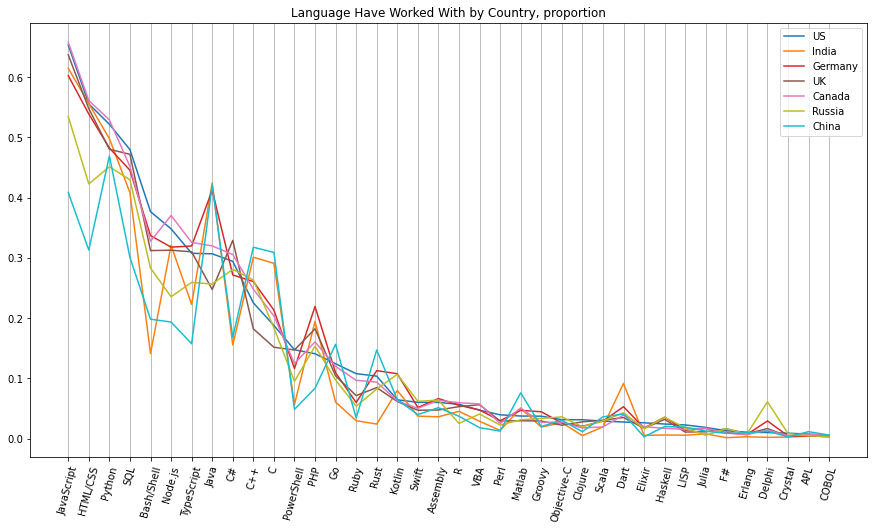

In [14]:
line_plot(df_lang_worked_joined, title0+' by Country')

This plot reveals us very interesting insights.  
Compared to other countries:
- Python is more popular than HTML/CSS in Russia and China. In fact, in China it is even more popular than JavaScript.
- Java is very popular in India, Germany and China.
- Only in the US PHP is less popular than PowerShell.
- Old Delphi is still widely used in Russia.
- India has a noticeable low use of Bash/Shell, Go, Rust.
- At the same time, Dart is very popular in India.


## Question 2: What operating systems were used the most among all respondents and in different countries?

Let's check the values in the column **OpSys**.

In [15]:
data_col = 'OpSys'
df_2021[data_col].value_counts()

Windows                              37758
Linux-based                          21088
MacOS                                20984
Windows Subsystem for Linux (WSL)     2743
Other (please specify):                575
BSD                                    146
Name: OpSys, dtype: int64

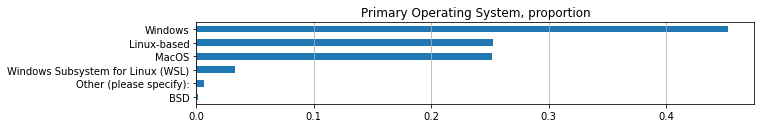

In [16]:
title0 = 'Primary Operating System'
df_OpSys = clean_and_plot(df_2021, col=data_col, title=title0)


Windows is by far the leading operating system. Next, Linux-based and MacOS are used by about the same amount of respondents.  

Let's look how the plots look like by country.

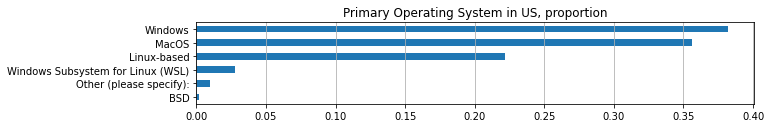

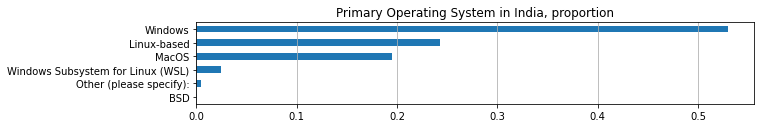

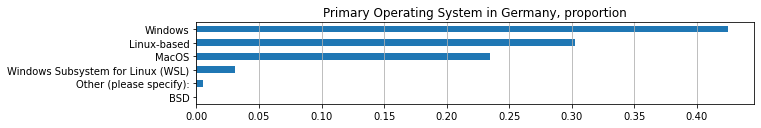

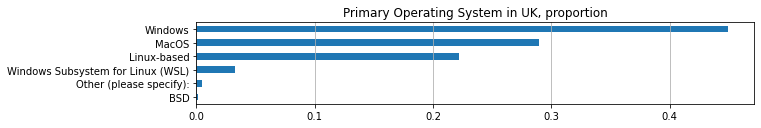

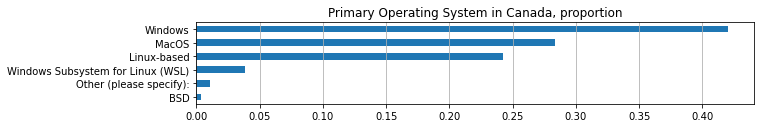

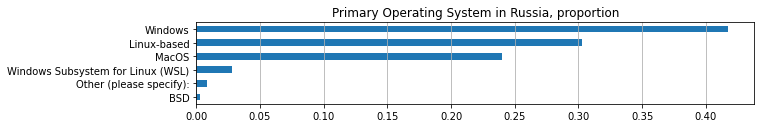

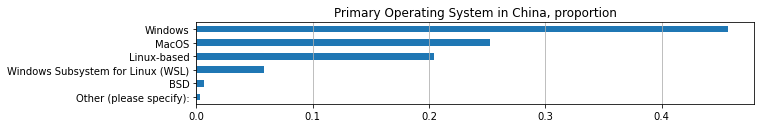

In [17]:
df_OpSys_us = clean_and_plot(df_us, col=data_col, col_suffix='_us', title=title0+' in US')
df_OpSys_in = clean_and_plot(df_in, col=data_col, col_suffix='_in', title=title0+' in India')
df_OpSys_ge = clean_and_plot(df_ge, col=data_col, col_suffix='_ge', title=title0+' in Germany')
df_OpSys_uk = clean_and_plot(df_uk, col=data_col, col_suffix='_uk', title=title0+' in UK')
df_OpSys_ca = clean_and_plot(df_ca, col=data_col, col_suffix='_ca', title=title0+' in Canada')
df_OpSys_ru = clean_and_plot(df_ru, col=data_col, col_suffix='_ru', title=title0+' in Russia')
df_OpSys_ch = clean_and_plot(df_ch, col=data_col, col_suffix='_ch', title=title0+' in China')


MacOS is actually very close to Windows in the US.

Again, I would like to compare proportions by country.

In [18]:
# combine DataFrames by country in one
df_OpSys_joined = df_OpSys_us.join(
    df_OpSys_in).join(
    df_OpSys_ge).join(
    df_OpSys_uk).join(
    df_OpSys_ca).join(
    df_OpSys_ru).join(
    df_OpSys_ch)
df_OpSys_joined = df_OpSys_joined.rename(columns={
        'count_us':'US',
        'count_in':'India',
        'count_ge':'Germany',
        'count_uk':'UK',
        'count_ca':'Canada',
        'count_ru':'Russia',
        'count_ch':'China'
})
df_OpSys_joined = df_OpSys_joined.sort_values(by=['US'], ascending=False)
df_OpSys_joined

,US,India,Germany,UK,Canada,Russia,China
value,,,,,,,
Windows,0.381803,0.529731,0.424533,0.449162,0.419987,0.417232,0.456872
MacOS,0.355965,0.194558,0.234667,0.289385,0.283201,0.240163,0.252133
Linux-based,0.221415,0.242984,0.302756,0.221676,0.242364,0.302578,0.204739
Windows Subsystem for Linux (WSL),0.027669,0.024165,0.031289,0.032626,0.038845,0.027815,0.057820
Other (please specify):,0.009746,0.005042,0.005689,0.005140,0.010624,0.008141,0.002844
BSD,0.001832,0.000951,0.000711,0.001117,0.003652,0.002714,0.006635


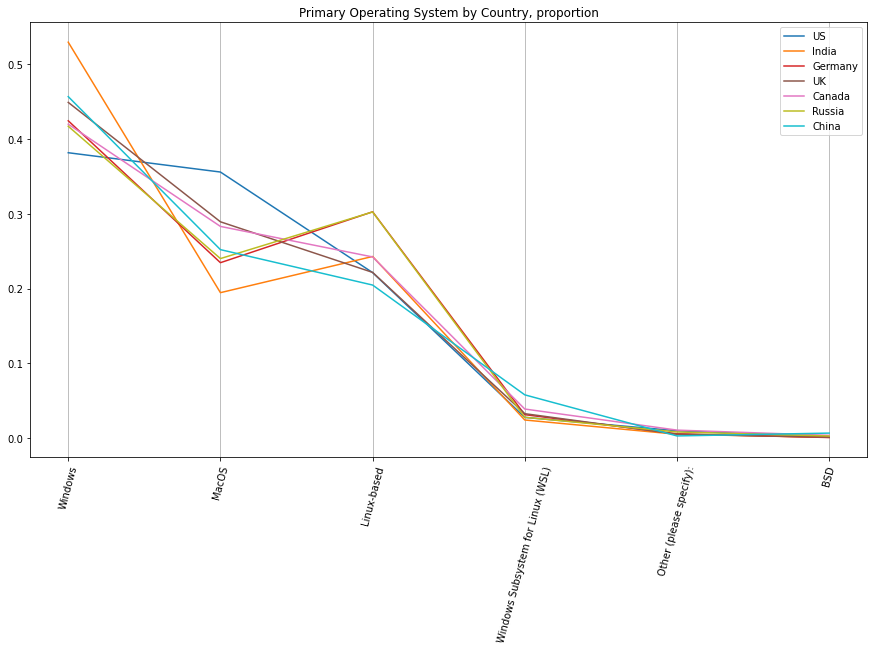

In [19]:
line_plot(df_OpSys_joined, title0+' by Country')

Here we also got some interesting results.  
Compared to other countries:
- US has the smallest proportion of Windows users and the biggest proportion of MacOS users.
- As opposed to US, India has the biggest proportion of Windows users and the smallest proportion of MacOS users.
- Russia and Germany have almost identical distributions.
- Linux-based OS is more popular than MacOS only in Russia, Germany and India.


## Question 3: What is the highest level of education among all respondents and in different countries?

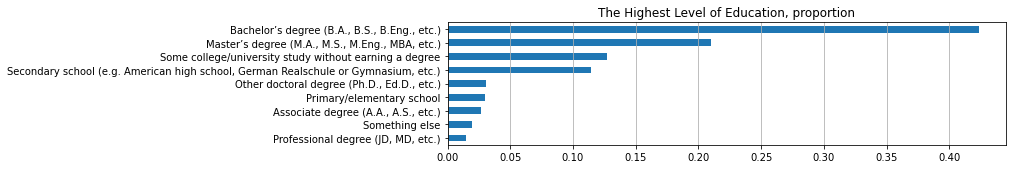

In [20]:
data_col = 'EdLevel'
title0 = 'The Highest Level of Education'
df_EdLevel = clean_and_plot(df_2021, col=data_col, title=title0)


Looks like almost half of the respondents have Bachelor's degree. Next big group, just a little over 20%, have Master's degree.

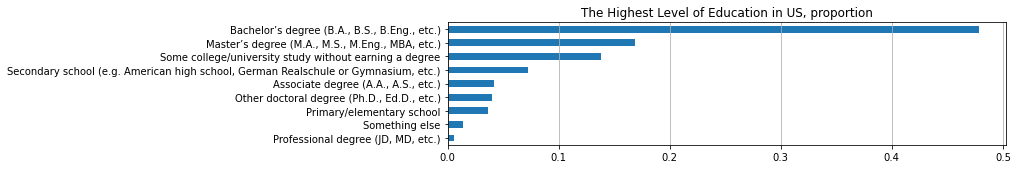

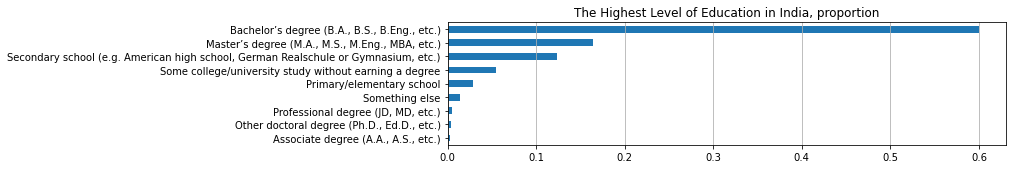

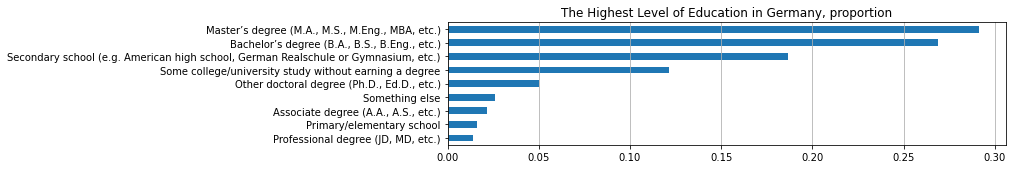

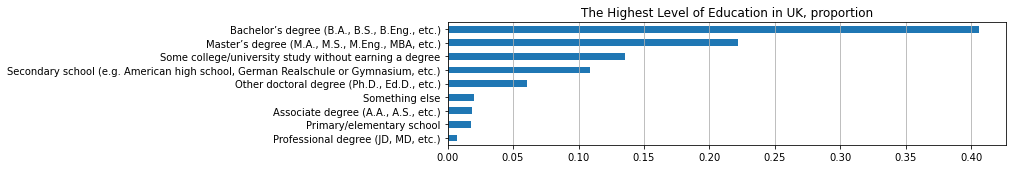

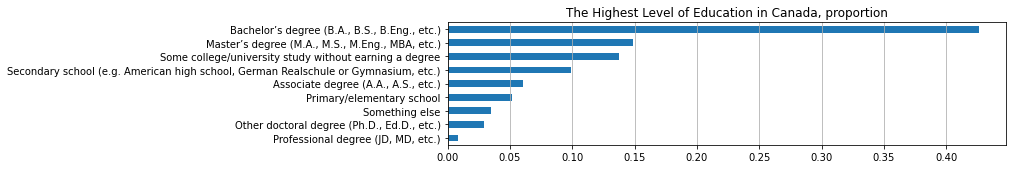

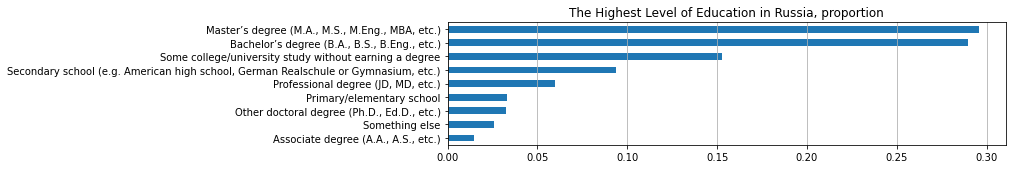

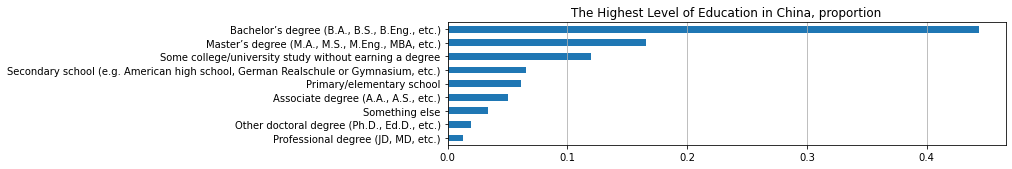

In [21]:
df_EdLevel_us = clean_and_plot(df_us, col=data_col, col_suffix='_us', title=title0+' in US')
df_EdLevel_in = clean_and_plot(df_in, col=data_col, col_suffix='_in', title=title0+' in India')
df_EdLevel_ge = clean_and_plot(df_ge, col=data_col, col_suffix='_ge', title=title0+' in Germany')
df_EdLevel_uk = clean_and_plot(df_uk, col=data_col, col_suffix='_uk', title=title0+' in UK')
df_EdLevel_ca = clean_and_plot(df_ca, col=data_col, col_suffix='_ca', title=title0+' in Canada')
df_EdLevel_ru = clean_and_plot(df_ru, col=data_col, col_suffix='_ru', title=title0+' in Russia')
df_EdLevel_ch = clean_and_plot(df_ch, col=data_col, col_suffix='_ch', title=title0+' in China')


We can see that in Germany and Russia the most responders have Master's degree, in other countries - Bachelor's degree.

Again, let's look at the distribution by country on one plot.

In [22]:
df_EdLevel_joined = df_EdLevel_us.join(
    df_EdLevel_in).join(
    df_EdLevel_ge).join(
    df_EdLevel_uk).join(
    df_EdLevel_ca).join(
    df_EdLevel_ru).join(
    df_EdLevel_ch)
df_EdLevel_joined = df_EdLevel_joined.rename(columns={
        'count_us':'US',
        'count_in':'India',
        'count_ge':'Germany',
        'count_uk':'UK',
        'count_ca':'Canada',
        'count_ru':'Russia',
        'count_ch':'China'
})
df_EdLevel_joined = df_EdLevel_joined.sort_values(by=['US'], ascending=False)
df_EdLevel_joined

,US,India,Germany,UK,Canada,Russia,China
value,,,,,,,
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.478480,0.600133,0.269156,0.405810,0.426295,0.289688,0.443602
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.168629,0.163828,0.291378,0.221676,0.149070,0.295794,0.165877
Some college/university study without earning a degree,0.137886,0.054895,0.121600,0.135866,0.137782,0.152646,0.119431
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.072410,0.123585,0.186489,0.108380,0.098938,0.093623,0.065403
"Associate degree (A.A., A.S., etc.)",0.041732,0.002474,0.021867,0.018771,0.060425,0.014925,0.050237
"Other doctoral degree (Ph.D., Ed.D., etc.)",0.039704,0.003901,0.049956,0.060559,0.029548,0.032564,0.019905
Primary/elementary school,0.036041,0.028256,0.016178,0.018101,0.051461,0.033243,0.061611
Something else,0.014129,0.013605,0.025778,0.019888,0.034529,0.025780,0.034123
"Professional degree (JD, MD, etc.)",0.006214,0.005423,0.014044,0.007374,0.008300,0.059701,0.013270


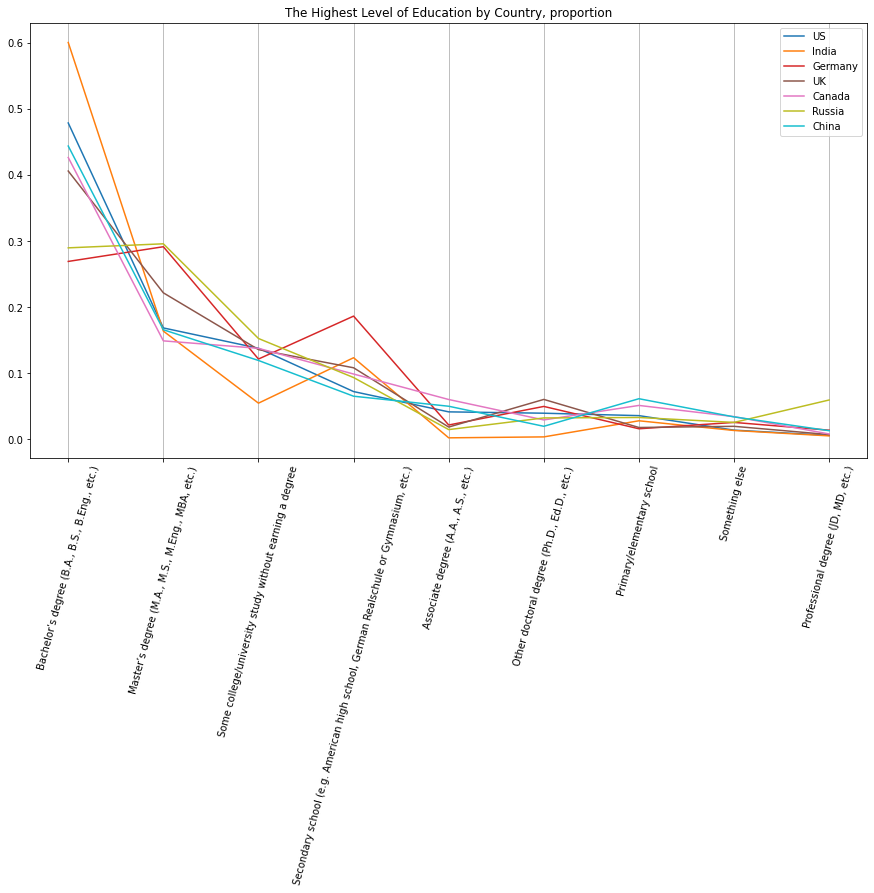

In [23]:
line_plot(df_EdLevel_joined, title0+' by Country')

Compared to other countries:
- India has by far highest proportion of respondents with Bachelor's degree.
- Doctoral degree is more popular in UK.
- Germany and Russia have the highest proportion of respondents with Master's degree.

I want to compare the total proportion of higher education (Bachelor's degree, Master's degree, and doctoral degree together).

In [24]:
# leave only needed data
df_HighEdLevel_joined = df_EdLevel_joined.drop([
    'Some college/university study without earning a degree',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
    'Associate degree (A.A., A.S., etc.)',
    'Primary/elementary school',
    'Something else',
    'Professional degree (JD, MD, etc.)'
], axis=0)
df_HighEdLevel_joined

,US,India,Germany,UK,Canada,Russia,China
value,,,,,,,
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.478480,0.600133,0.269156,0.405810,0.426295,0.289688,0.443602
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.168629,0.163828,0.291378,0.221676,0.149070,0.295794,0.165877
"Other doctoral degree (Ph.D., Ed.D., etc.)",0.039704,0.003901,0.049956,0.060559,0.029548,0.032564,0.019905


In [25]:
# swap rows and columns
df_HighEdLevel_transposed = df_HighEdLevel_joined.T
df_HighEdLevel_transposed['total'] = df_HighEdLevel_transposed.sum(axis=1)
df_HighEdLevel_transposed = df_HighEdLevel_transposed.sort_values(by=['total'], ascending=False)
df_HighEdLevel_transposed

value,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Other doctoral degree (Ph.D., Ed.D., etc.)",total
India,0.600133,0.163828,0.003901,0.767862
UK,0.405810,0.221676,0.060559,0.688045
US,0.478480,0.168629,0.039704,0.686813
China,0.443602,0.165877,0.019905,0.629384
Russia,0.289688,0.295794,0.032564,0.618046
Germany,0.269156,0.291378,0.049956,0.610489
Canada,0.426295,0.149070,0.029548,0.604914


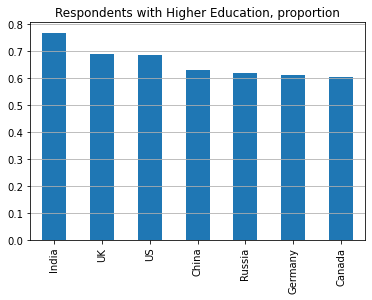

In [26]:
df_HighEdLevel_transposed.plot.bar(y='total', title='Respondents with Higher Education, proportion', legend=None).grid(axis='y');

India is leading by proportion of respondents with higher education.  
UK and US go next, almost 1% behind.

## Question 4: How well can we predict the age of respondents?

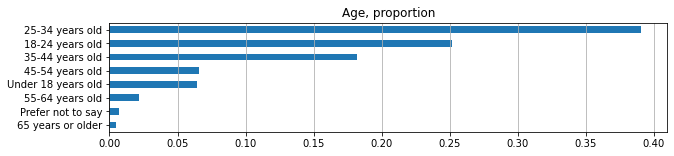

In [27]:
df_Age = clean_and_plot(df_2021, col='Age', title='Age')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


### Clean the data

We will start with original dataset.

In [29]:
df_2021.shape

(83439, 48)

Let's check how much data is missing.

In [30]:
# show proportion of missing data by column
df_2021.isnull().mean()

ResponseId                      0.000000
MainBranch                      0.000000
Employment                      0.001390
Country                         0.000000
US_State                        0.821187
UK_Country                      0.947051
EdLevel                         0.003751
Age1stCode                      0.002349
LearnCode                       0.005705
YearsCode                       0.021549
YearsCodePro                    0.266338
DevType                         0.203202
OrgSize                         0.272211
Currency                        0.267968
CompTotal                       0.434521
CompFreq                        0.374993
LanguageHaveWorkedWith          0.012968
LanguageWantToWorkWith          0.079315
DatabaseHaveWorkedWith          0.166505
DatabaseWantToWorkWith          0.301298
PlatformHaveWorkedWith          0.375172
PlatformWantToWorkWith          0.501204
WebframeHaveWorkedWith          0.260454
WebframeWantToWorkWith          0.375652
MiscTechHaveWork

Our response variable (Age) has 1.24% of missing data.
We have to drop them in order to make prediction.

In [31]:
# drop rows with na in response variable (Age)
drop_target_na = df_2021.dropna(subset=['Age'])
drop_target_na.shape

(82407, 48)

We will clean categorical and numerical data separately.

In [32]:
# split on numeric and categorical

# List of categorical columns
cat_cols = [col for col in drop_target_na.columns if drop_target_na[col].dtype == "object"]
# List of numerical columns
num_cols = [col for col in drop_target_na.columns if drop_target_na[col].dtype != "object"]

print(f'categorical: {len(cat_cols)}\nnumerical: {len(num_cols)}')

categorical: 45
numerical: 3


#### Clean numerical data

Fist, let's look closer at numerical data.

In [33]:
drop_target_na[num_cols].isnull().mean()

ResponseId             0.000000
CompTotal              0.428811
ConvertedCompYearly    0.432876
dtype: float64

Almost half of data in CompTotal and ConvertedCompYearly is empty.  
So we can't just drop those records.  
We will fill all missing values with the median of the column, because we saw earlier, that CompTotal has obvious outliers.

In [34]:
fill_median = lambda col: col.fillna(col.median()) if (col.name in num_cols) else col 

#Fill all missing values with the median of the column.
fill_num_na = drop_target_na.apply(fill_median, axis=0) 
fill_num_na[num_cols].isnull().mean()

ResponseId             0.0
CompTotal              0.0
ConvertedCompYearly    0.0
dtype: float64

There are some extremely large numbers in CompTotal, which will throw an error in our model.

In [35]:
fill_num_na[fill_num_na['CompTotal']>10**18][num_cols]

,ResponseId,CompTotal,ConvertedCompYearly
103,104,1.000000e+29,56211.0
6378,6379,1.000000e+74,56211.0
18919,18920,8.000000e+52,56211.0
62417,62418,7.000000e+39,56211.0


Since there are just 4 of them, we will just remove them.

In [36]:
print(fill_num_na.shape)
fill_num_na = fill_num_na.drop(fill_num_na[fill_num_na['CompTotal']>10**18].index)
print(fill_num_na.shape)


(82407, 48)
(82403, 48)


#### Clean categorical data

Now we need to clean categorical data.

In [37]:
# make a copy of the list with categorical columns and remove the response variable.
cat_cols2 = cat_cols.copy()
cat_cols2.remove('Age')
cat_cols2

['MainBranch',
 'Employment',
 'Country',
 'US_State',
 'UK_Country',
 'EdLevel',
 'Age1stCode',
 'LearnCode',
 'YearsCode',
 'YearsCodePro',
 'DevType',
 'OrgSize',
 'Currency',
 'CompFreq',
 'LanguageHaveWorkedWith',
 'LanguageWantToWorkWith',
 'DatabaseHaveWorkedWith',
 'DatabaseWantToWorkWith',
 'PlatformHaveWorkedWith',
 'PlatformWantToWorkWith',
 'WebframeHaveWorkedWith',
 'WebframeWantToWorkWith',
 'MiscTechHaveWorkedWith',
 'MiscTechWantToWorkWith',
 'ToolsTechHaveWorkedWith',
 'ToolsTechWantToWorkWith',
 'NEWCollabToolsHaveWorkedWith',
 'NEWCollabToolsWantToWorkWith',
 'OpSys',
 'NEWStuck',
 'NEWSOSites',
 'SOVisitFreq',
 'SOAccount',
 'SOPartFreq',
 'SOComm',
 'NEWOtherComms',
 'Gender',
 'Trans',
 'Sexuality',
 'Ethnicity',
 'Accessibility',
 'MentalHealth',
 'SurveyLength',
 'SurveyEase']

There is a column **US_State** which should be relevant only for US residents.  
Let's check, that we are right.

In [38]:
fill_num_na[(fill_num_na['Country']!='United States of America') & fill_num_na['US_State'].notna()]

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly


We are right. So we can combine these columns in one.

In [39]:
fill_num_na.loc[fill_num_na['Country']=='United States of America', 'Country'] = 'US/'+fill_num_na['US_State']
fill_num_na = fill_num_na.drop('US_State', axis=1)
cat_cols2.remove('US_State')
fill_num_na.shape

(82403, 47)

We can do the same steps with **UK_Country**.

In [40]:
fill_num_na[(fill_num_na['Country']!='United Kingdom of Great Britain and Northern Ireland') & fill_num_na['UK_Country'].notna()]

,ResponseId,MainBranch,Employment,Country,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,YearsCodePro,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly


In [41]:
fill_num_na.loc[fill_num_na['Country']=='United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'UK/'+fill_num_na['UK_Country']
fill_num_na = fill_num_na.drop('UK_Country', axis=1)
cat_cols2.remove('UK_Country')
fill_num_na.shape

(82403, 46)

Some columns contain multiple values separated by semicolon.  
We will skip them for now and clean them later.

In [42]:
skip = ['LearnCode','DevType',
        'LanguageHaveWorkedWith','LanguageWantToWorkWith',
        'DatabaseHaveWorkedWith','DatabaseWantToWorkWith',
        'PlatformHaveWorkedWith','PlatformWantToWorkWith',
        'WebframeHaveWorkedWith','WebframeWantToWorkWith',
        'MiscTechHaveWorkedWith','MiscTechWantToWorkWith',
        'ToolsTechHaveWorkedWith','ToolsTechWantToWorkWith',
        'NEWCollabToolsHaveWorkedWith','NEWCollabToolsWantToWorkWith',
        'NEWStuck','NEWSOSites', 'Ethnicity', 'Accessibility', 'Sexuality', 'Gender', 'MentalHealth']
cat_features = list(set(cat_cols2)-set(skip))
num_cat_df = fill_num_na.drop(skip, axis=1)
print(num_cat_df.shape)
print(num_cat_df.columns)

(82403, 23)
Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'Age1stCode', 'YearsCode', 'YearsCodePro', 'OrgSize', 'Currency',
       'CompTotal', 'CompFreq', 'OpSys', 'SOVisitFreq', 'SOAccount',
       'SOPartFreq', 'SOComm', 'NEWOtherComms', 'Age', 'Trans', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')


Now we will remove ResponseId, since it is just a record id and split the dataset into explanatory and response variables.

In [43]:
# Split into explanatory and response variables
X = num_cat_df.drop(['Age','ResponseId'], axis=1)
y = num_cat_df['Age']

X.shape

(82403, 21)

Now we need to create dummies for all categorical features.

In [44]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - DataFrame, with categorical variables to dummy
    cat_cols - list, names of the categorical columns
    dummy_na - Bool, holding whether to dummy NA vals of categorical columns or not

    OUTPUT:
    df - a new DataFrame that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in cat_cols:
        try:
            # for each categorical column add dummy column and drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [45]:
X = create_dummy_df(X, cat_features, dummy_na=True)
X.shape

(82403, 572)

Now we need to create dummies for skipped columns.  
Let's look at one of them.

In [46]:
fill_num_na['LearnCode'].head()

0    Coding Bootcamp;Other online resources (ex: vi...
1    Other online resources (ex: videos, blogs, etc...
2    Other online resources (ex: videos, blogs, etc...
3                                                  NaN
4                              Friend or family member
Name: LearnCode, dtype: object

In [47]:
fill_num_na['LearnCode'].str.get_dummies(sep=';')

,Books / Physical media,Coding Bootcamp,Colleague,Friend or family member,Online Courses or Certification,Online Forum,Other (please specify):,"Other online resources (ex: videos, blogs, etc)",School
0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
83434,0,0,0,0,0,1,0,1,1
83435,1,0,0,0,1,1,0,1,1
83436,0,0,0,0,0,0,0,0,1
83437,1,0,0,0,1,0,0,0,0


This way we can create dummies for all of them.

In [48]:
for col in skip:
    X = pd.concat([X, fill_num_na[col].str.get_dummies(sep=';')], axis=1)
X.shape

(82403, 909)

Now our data is ready for training and testing the model.  
Our response variable is categorical, so need to use a classification algorithm. I chose the random forest classifier.

In [49]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


In [50]:
# Create and fit the model to the training data
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

# Show cross validation score
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(f'{cv} => mean = {cv.mean()}')


[0.6987085  0.69974863 0.70899792 0.70891123 0.71133842] => mean = 0.7055409421439338


In [51]:
# Make predictions for the test set
y_pred_test = rf.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score

# View accuracy score
accuracy_score(y_test, y_pred_test)


0.7092755147445492

With just default parameters for the model we could predict the Age with 71% accuracy.